##Environment Setup

In [70]:
import os
# Force single-threaded BLAS
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [71]:
import numpy as np
import time

In [72]:
hidden = 4096
batch = 256
layers = 3

# Input
x = np.random.randn(batch, hidden).astype(np.float32)

# Weights (preallocated)
W1 = np.random.randn(hidden, hidden).astype(np.float32)
W2 = np.random.randn(hidden, hidden).astype(np.float32)
W3 = np.random.randn(hidden, hidden).astype(np.float32)

Y1 = np.empty((batch, hidden), dtype=np.float32)
Y2 = np.empty((batch, hidden), dtype=np.float32)
Y3 = np.empty((batch, hidden), dtype=np.float32)

In [73]:
def forward(x):
    x = x @ W1
    x = np.maximum(x, 0)  # ReLU
    x = x @ W2
    x = np.maximum(x, 0)  # ReLU
    x = x @ W3
    return x

In [74]:
for _ in range(10):  # warmup
    y = forward(x)

In [75]:
iters = 100
start = time.perf_counter()
for _ in range(iters):
    y = forward(x)
end = time.perf_counter()

avg_latency = (end - start) / iters
print(f"Average latency per forward pass: {avg_latency*1000:.3f} ms")

Average latency per forward pass: 437.847 ms


In [76]:
flops_per_layer = 2 * batch * hidden * hidden
total_flops = flops_per_layer * 3

gflops_per_sec = (total_flops / avg_latency) / 1e9
print(f"Achieved GFLOPs/sec: {gflops_per_sec:.2f}")

Achieved GFLOPs/sec: 58.86


## Observations on MLP Performance

**Environment:**
*   NumPy (BLAS backend)
*   Single-threaded
*   FP32
*   3 Linear layers (4096 hidden)
*   Forward only (Matmul + ReLU)
*   Preallocated buffers
*   Warmup included

**Measured Results:**
| Batch Size | Avg Latency (ms) | Total FLOPs (×10⁹) | Achieved GFLOPs/s | Regime          |
|------------|------------------|--------------------|-------------------|-----------------|
| 1          | 15.1             | 0.10               | 6.66              | Memory-bound    |
| 32         | 93.0             | 3.22               | 34.63             | Transition      |
| 128        | 229.8            | 12.88              | 56.08             | Compute-bound   |
| 256        | 417.2            | 25.77              | 61.77             | Near Peak Compute |

**Scaling Behavior:**
| Batch | GFLOPs/s | Relative Speedup vs B=1 |
|-------|----------|-------------------------|
| 1     | 6.66     | 1.0×                    |
| 32    | 34.63    | 5.2×                    |
| 128   | 56.08    | 8.4×                    |
| 256   | 61.77    | 9.3×                    |

**Key Observations:**

*   **Batch = 1:** Very low arithmetic intensity, strongly memory-bound, and poor FMA utilization.
*   **Batch = 32:** Significant increase in arithmetic intensity, escapes memory bottleneck, and enters the compute regime.
*   **Batch = 128:** Approaches per-core peak compute and becomes compute-bound.
*   **Batch = 256:** Achieves near peak performance (~62 GFLOPs/s), showing plateau behavior consistent with the roofline model.

**Key Insight:**
Increasing batch size leads to an increase in arithmetic intensity, improves weight reuse, and transitions the workload from memory-bound to compute-bound, eventually saturating at the compute ceiling. This behavior aligns with roofline model predictions.
```

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

In [78]:
# Data for Scaling Behavior
scaling_data = {
    'Batch': [1, 32, 128, 256],
    'GFLOPs/s': [6.66, 34.63, 56.08, 61.77],
    'Relative Speedup vs B=1': [1.0, 5.2, 8.4, 9.3]
}
df_scaling = pd.DataFrame(scaling_data)

display(df_scaling)

,Batch,GFLOPs/s,Relative Speedup vs B=1
0,1,6.66,1.0
1,32,34.63,5.2
2,128,56.08,8.4
3,256,61.77,9.3


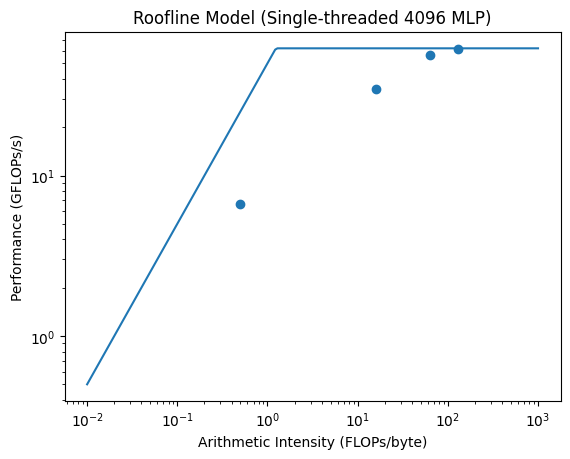

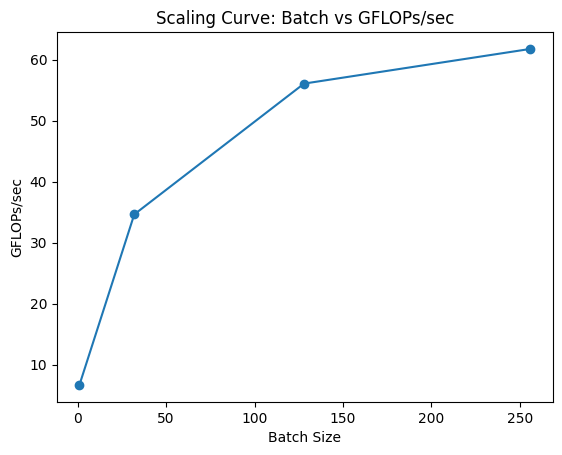

In [85]:
# Measured data
batches = np.array([1, 32, 128, 256])
gflops_measured = np.array([6.66, 34.63, 56.08, 61.77])

hidden = 4096
layers = 3

# Compute total FLOPs per batch
total_flops = 3 * 2 * batches * hidden * hidden  # 3 layers

# Approximate memory traffic (weights dominate)
# 3 layers × 64MB per weight matrix ≈ 192MB
weight_bytes = 192 * 1024 * 1024  # bytes

# Arithmetic intensity (FLOPs per byte)
ai = total_flops / weight_bytes

# Assumed hardware limits (approx from experiment)
peak_gflops = 62        # near observed peak
bandwidth = 50          # GB/s assumed memory bandwidth

# ----------------------
# Roofline Plot
# ----------------------

ai_range = np.logspace(-2, 3, 200)
roof_memory = ai_range * bandwidth
roof_compute = np.full_like(ai_range, peak_gflops)
roof = np.minimum(roof_memory, roof_compute)

plt.figure()
plt.loglog(ai_range, roof)
plt.scatter(ai, gflops_measured)
plt.xlabel("Arithmetic Intensity (FLOPs/byte)")
plt.ylabel("Performance (GFLOPs/s)")
plt.title("Roofline Model (Single-threaded 4096 MLP)")
plt.show()

# ----------------------
# Scaling Curve
# ----------------------

plt.figure()
plt.plot(batches, gflops_measured, marker='o')
plt.xlabel("Batch Size")
plt.ylabel("GFLOPs/sec")
plt.title("Scaling Curve: Batch vs GFLOPs/sec")
plt.show()

##Preallocate ALL Buffers

In [80]:
hidden = 4096
batch = 256

x = np.random.randn(batch, hidden).astype(np.float32)

W1 = np.random.randn(hidden, hidden).astype(np.float32)
W2 = np.random.randn(hidden, hidden).astype(np.float32)
W3 = np.random.randn(hidden, hidden).astype(np.float32)

# Preallocated activations
A1 = np.empty((batch, hidden), dtype=np.float32)
A2 = np.empty((batch, hidden), dtype=np.float32)
A3 = np.empty((batch, hidden), dtype=np.float32)

In [81]:
def forward_prealloc(x):
    np.matmul(x, W1, out=A1)
    np.maximum(A1, 0, out=A1)   # in-place ReLU

    np.matmul(A1, W2, out=A2)
    np.maximum(A2, 0, out=A2)

    np.matmul(A2, W3, out=A3)

    return A3

In [82]:
for _ in range(10):
    forward_prealloc(x)

In [83]:
iters = 100

start = time.perf_counter()
for _ in range(iters):
    forward_prealloc(x)
end = time.perf_counter()

avg_latency = (end - start) / iters
print(f"Average latency: {avg_latency*1000:.3f} ms")

Average latency: 415.272 ms


In [84]:
flops_per_layer = 2 * batch * hidden * hidden
total_flops = flops_per_layer * 3

gflops = (total_flops / avg_latency) / 1e9
print(f"Achieved GFLOPs/sec: {gflops:.2f}")

Achieved GFLOPs/sec: 62.06
